In [1]:
import gym

In [3]:
# 定义环境
from typing import Tuple
from gym.core import Env


class MyWrapper(gym.Wrapper):
    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        self.step_n += 1
        done = True if self.step_n >= 200 else terminated or truncated
        return state, reward, done, info


env = MyWrapper()

env.reset()

array([0.99980724, 0.01963409, 0.8967923 ], dtype=float32)

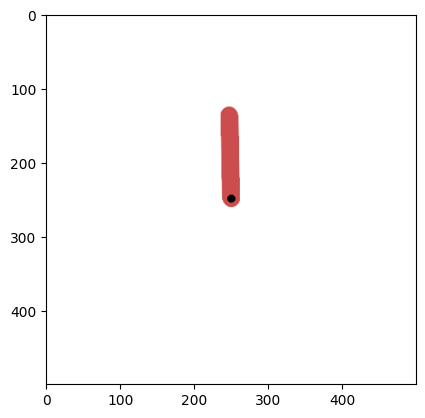

In [4]:
from matplotlib import pyplot as plt


def show():
    plt.imshow(env.render())
    plt.show()


show()

In [5]:
# 测试游戏环境
def test_env():
    state = env.reset()
    print('这个游戏的状态用3个数字表示,我也不知道这3个数字分别是什么意思,反正这3个数字就能描述游戏全部的状态')
    print('state=', state)
    # state= [-0.91304934 -0.40784913  0.271098  ]

    print('这个游戏的动作是个-2到+2之间的连续值')
    print('env.action_space=', env.action_space)
    # env.action_space= Box(-2.0, 2.0, (1,), float32)

    print('随机一个动作')
    action = env.action_space.sample()
    print('action=', action)
    # action= [-0.14946985]

    print('执行一个动作,得到下一个状态,奖励,是否结束')
    state, reward, over, _ = env.step(action)

    print('state=', state)
    # state= [-0.5629868  0.8264659  2.7232552]

    print('reward=', reward)
    # reward= -4.456876123969679

    print('over=', over)
    # over= False


test_env()

这个游戏的状态用3个数字表示,我也不知道这3个数字分别是什么意思,反正这3个数字就能描述游戏全部的状态
state= [ 0.4377228  -0.89910996  0.69723487]
这个游戏的动作是个-2到+2之间的连续值
env.action_space= Box(-2.0, 2.0, (1,), float32)
随机一个动作
action= [-0.28050974]
执行一个动作,得到下一个状态,奖励,是否结束
state= [ 0.43686062 -0.8995292  -0.01917405]
reward= -1.2980170376390543
over= False


In [6]:
import torch

# 计算动作的模型,也是真正要用的模型
model = torch.nn.Sequential(
    torch.nn.Linear(3, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 11),
)

# 经验网络,用于评估一个状态的分数
next_model = torch.nn.Sequential(
    torch.nn.Linear(3, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 11),
)

# 把model的参数复制给next_model
next_model.load_state_dict(model.state_dict())

model, next_model

(Sequential(
   (0): Linear(in_features=3, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=11, bias=True)
 ),
 Sequential(
   (0): Linear(in_features=3, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=11, bias=True)
 ))

In [7]:
import random


def get_action(state):
    # 走神经网络，得到一个动作
    state = torch.FloatTensor(state).reshape(1, 3)
    action = model(state).argmax().item()

    if random.random() < 0.01:
        action = random.choice(range(11))

    # 离散动作连续化
    action_countinuous = action
    action_countinuous /= 10
    action_countinuous *= 4
    action_countinuous -= 2

    return action, action_countinuous


get_action([0.29292667, 0.9561349, 1.0957013])

(4, -0.3999999999999999)

In [8]:
# 样本池
datas = []


# 向样本池中添加N条数据,删除M条最古老的数据
def update_data():
    old_count = len(datas)

    # 玩到新增了N个数据为止
    while len(datas) - old_count < 200:
        # 初始化游戏
        state = env.reset()

        # 玩到游戏结束为止
        over = False
        while not over:
            # 根据当前状态得到一个动作
            action, action_continuous = get_action(state)

            # 执行动作,得到反馈
            next_state, reward, over, _ = env.step([action_continuous])

            # 记录数据样本
            datas.append((state, action, reward, next_state, over))

            # 更新游戏状态,开始下一个动作
            state = next_state

    update_count = len(datas) - old_count
    drop_count = max(len(datas) - 5000, 0)

    # 数据上限,超出时从最古老的开始删除
    while len(datas) > 5000:
        datas.pop(0)

    return update_count, drop_count


update_data(), len(datas)

((200, 0), 200)

In [9]:
# 获取一批数据样本
def get_sample():
    # 从样本池中采样
    samples = random.sample(datas, 64)

    # [b, 3]
    state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)
    # [b, 1]
    action = torch.LongTensor([i[1] for i in samples]).reshape(-1, 1)
    # [b, 1]
    reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1)
    # [b, 3]
    next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 3)
    # [b, 1]
    over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1)

    return state, action, reward, next_state, over


state, action, reward, next_state, over = get_sample()

state, action, reward, next_state, over

C:\Users\25338\AppData\Local\Temp\ipykernel_15160\3739385932.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3)


(tensor([[-9.9740e-01, -7.2001e-02, -5.9921e-02],
         [-9.9997e-01,  8.1255e-03,  1.1934e-01],
         [-9.9696e-01,  7.7891e-02,  1.4021e-02],
         [-9.9790e-01, -6.4792e-02, -7.1235e-02],
         [-9.9767e-01, -6.8230e-02,  1.4666e-02],
         [-9.9862e-01,  5.2489e-02, -5.8681e-02],
         [-9.9998e-01, -6.3828e-03,  8.3207e-03],
         [-9.9830e-01,  5.8338e-02,  2.8272e-03],
         [-9.9874e-01, -5.0229e-02,  1.2317e-01],
         [-9.9895e-01,  4.5912e-02,  7.4398e-02],
         [-9.9738e-01, -7.2304e-02,  6.0788e-03],
         [-9.9843e-01,  5.6061e-02, -5.5969e-02],
         [-9.9921e-01, -3.9794e-02,  1.1425e-02],
         [-9.5384e-01, -3.0031e-01, -7.9047e-01],
         [-9.9956e-01,  2.9635e-02, -2.0853e-02],
         [-8.3971e-01,  5.4303e-01, -8.1854e-01],
         [-9.9781e-01,  6.6185e-02,  3.9541e-02],
         [-9.9687e-01,  7.9027e-02, -4.9327e-01],
         [-9.9977e-01,  2.1611e-02,  9.3857e-02],
         [-9.9712e-01, -7.5887e-02,  7.1851e-02],


In [10]:
def get_value(state, action):
    # 使用状态计算出动作的logits
    # [b, 3] -> [b, 11]
    value = model(state)

    # 根据实际使用的action取出每一个值
    # 这个值就是模型评估的在该状态下,执行动作的分数
    # 在执行动作前,显然并不知道会得到的反馈和next_state
    # 所以这里不能也不需要考虑next_state和reward
    # [b, 11] -> [b, 1]
    value = value.gather(dim=1, index=action)

    return value


get_value(state, action)

tensor([[ 0.2390],
        [ 0.2113],
        [ 0.2075],
        [ 0.2408],
        [ 0.2151],
        [ 0.2153],
        [-0.2126],
        [ 0.2050],
        [ 0.2029],
        [ 0.2114],
        [ 0.2186],
        [ 0.2136],
        [ 0.2113],
        [ 0.4044],
        [ 0.2084],
        [ 0.2707],
        [ 0.2096],
        [ 0.3112],
        [ 0.2109],
        [ 0.1985],
        [ 0.2213],
        [ 0.2340],
        [ 0.2054],
        [ 0.7814],
        [ 0.2190],
        [ 0.2035],
        [ 0.2056],
        [ 0.8823],
        [ 0.9028],
        [ 0.2128],
        [ 0.8967],
        [ 0.2032],
        [ 0.1806],
        [ 0.3827],
        [ 0.2063],
        [ 0.2322],
        [ 0.4127],
        [ 0.3767],
        [ 0.2068],
        [ 0.1992],
        [ 0.2105],
        [ 0.2109],
        [ 0.2028],
        [ 0.2128],
        [ 0.2033],
        [ 0.2341],
        [ 0.1985],
        [ 0.2033],
        [ 0.2078],
        [ 0.2182],
        [ 0.2126],
        [ 0.2152],
        [ 0.

In [11]:
def get_target(reward, next_state, over):
    # 上面已经把模型认为的状态下执行动作的分数给评估出来了
    # 下面使用next_state和reward计算真实的分数
    # 针对一个状态,它到底应该多少分,可以使用以往模型积累的经验评估
    # 这也是没办法的办法,因为显然没有精确解,这里使用延迟更新的next_model评估

    # 使用next_state计算下一个状态的分数
    # [b, 3] -> [b, 11]
    with torch.no_grad():
        target = next_model(next_state)

    # 取所有动作中分数最大的
    # [b, 11] -> [b, 1]
    target = target.max(dim=1)[0]
    target = target.reshape(-1, 1)

    # 下一个状态的分数乘以一个系数,相当于权重
    target *= 0.98

    # 如果next_state已经游戏结束,则next_state的分数是0
    # 因为如果下一步已经游戏结束,显然不需要再继续玩下去,也就不需要考虑next_state了.
    # [b, 1] * [b, 1] -> [b, 1]
    target *= 1 - over

    # 加上reward就是最终的分数
    # [b, 1] + [b, 1] -> [b, 1]
    target += reward

    return target


get_target(reward, next_state, over)

tensor([[-9.2087],
        [-9.6202],
        [-9.1851],
        [-9.2523],
        [-9.2517],
        [-9.3337],
        [-9.5682],
        [-9.2940],
        [-9.3348],
        [-9.3856],
        [-9.2263],
        [-9.3108],
        [-9.4230],
        [-7.6978],
        [-9.4757],
        [-6.4829],
        [-9.2598],
        [-9.1383],
        [-9.5331],
        [-9.2046],
        [-9.4257],
        [-9.5764],
        [-9.2252],
        [-6.7701],
        [-9.2058],
        [-9.6604],
        [-9.4705],
        [-7.7718],
        [-8.3754],
        [-9.1324],
        [-9.0127],
        [-9.5503],
        [-6.2981],
        [-7.4710],
        [-9.3077],
        [-9.4751],
        [-6.0685],
        [-9.4556],
        [-9.3290],
        [-9.2102],
        [-9.6430],
        [-9.0699],
        [-9.5765],
        [-9.3861],
        [-9.3964],
        [-9.5333],
        [-9.2031],
        [-9.2923],
        [-9.6391],
        [-9.1093],
        [-9.2014],
        [-9.0626],
        [-9.

In [12]:
from IPython import display


def test(play):
    # 初始化游戏
    state = env.reset()

    # 记录反馈值的和,这个值越大越好
    reward_sum = 0

    # 玩到游戏结束为止
    over = False
    while not over:
        # 根据当前状态得到一个动作
        _, action_continuous = get_action(state)

        # 执行动作,得到反馈
        state, reward, over, _ = env.step([action_continuous])
        reward_sum += reward

        # 打印动画
        if play and random.random() < 0.2:  # 跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


test(play=False)

-1780.1645326364946

In [13]:
def train():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    loss_fn = torch.nn.MSELoss()

    # 训练N次
    for epoch in range(200):
        # 更新N条数据
        update_count, drop_count = update_data()

        # 每次更新过数据后,学习N次
        for i in range(200):
            # 采样一批数据
            state, action, reward, next_state, over = get_sample()

            # 计算一批样本的value和target
            value = get_value(state, action)
            target = get_target(reward, next_state, over)

            # 更新参数
            loss = loss_fn(value, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 把model的参数复制给next_model
            if (i + 1) % 50 == 0:
                next_model.load_state_dict(model.state_dict())

        if epoch % 20 == 0:
            test_result = sum(test(play=False) for _ in range(20)) / 20
            print(epoch, len(datas), update_count, drop_count, test_result)


train()

0 400 200 0 -1376.7479341930564
20 4400 200 0 -1253.6501484190353
40 5000 200 200 -1106.6997962946493
60 5000 200 200 -659.3476702286664
80 5000 200 200 -861.0767388690725
100 5000 200 200 -504.651884407562
120 5000 200 200 -833.360431098186
140 5000 200 200 -163.05160088955535
160 5000 200 200 -158.13197110904343
180 5000 200 200 -229.6168233269596


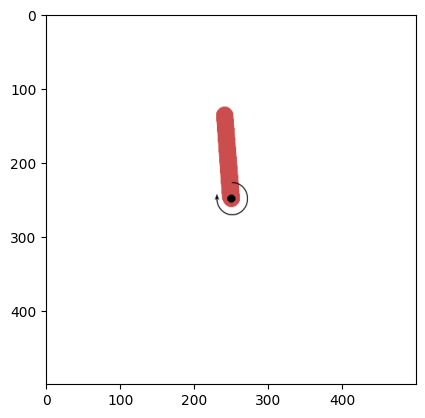

-3.3552067577342606

In [14]:
test(play=True)